In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/maximilianstumpf/Desktop/SS25/Wirtschaftsinformatik/Uplift-Modeling/Data/data_information.csv")

## Data Preparation ##

In [3]:
print(f"Dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
df.head()

Dimensions: 20,000 rows x 70 columns


,treatment,months_since_recent_account_opened,total_high_credit_limit,balance_to_credit_ratio,total_balance_excl_mortgage,num_satisfactory_revolving_accounts,avg_balance_revolving_accounts,num_bank_installment_accounts,months_since_oldest_bank_installment_account_opened,num_financial_installment_accounts,...,region_B,region_C,missing_recent_account_opened,missing_avg_balance_revolving,missing_oldest_bank_installment_account,missing_oldest_mortgage_account,missing_recent_mortgage_deal,missing_personal_balance_to_limit_ratio,purchase,unique_id
0,1,92.000000,24300.0,5.00000,1214.0,0,1767.197203,0.0,99.789583,1.0,...,0,0,0,1,1,1,1,1,0,1
1,0,11.000000,798991.0,6.50000,9680.0,0,1767.197203,0.0,99.789583,1.0,...,0,1,0,1,1,0,1,1,1,2
2,0,29.883391,0.0,36.09506,0.0,0,1767.197203,0.0,99.789583,0.0,...,0,0,1,1,1,1,1,1,0,3
3,0,29.883391,0.0,36.09506,0.0,0,1767.197203,0.0,99.789583,0.0,...,0,1,1,1,1,1,1,1,0,4
4,0,29.883391,0.0,36.09506,0.0,0,1767.197203,0.0,99.789583,0.0,...,0,0,1,1,1,1,1,1,0,5


In [4]:
df.drop(columns=["unique_id"], inplace=True)

#### Check treatment and outcome distributions ####
Uplift modeling requires a balanced 2x2 table of (control vs. treated) x (non-responder vs responder)

In [5]:
print("Treatment Distribution:", df["treatment"].value_counts(dropna=False), "\n")
print("Outcome Distribution:", df["purchase"].value_counts(dropna=False), "\n")

Treatment Distribution: treatment
1    10032
0     9968
Name: count, dtype: int64 

Outcome Distribution: purchase
1    11201
0     8799
Name: count, dtype: int64 



#### First Sanity Check ####
Treated customers should not buy less than control. The treated purchase rate should be >= to the control rate to justify running an uplift model.

In [6]:
ct = pd.crosstab(df["treatment"], df["purchase"], normalize = "index")
display(ct.style.format("{:2%}").set_caption("Outcome rate by treatment flag"))

purchase,0,1
treatment,,
0,44.321830%,55.678170%
1,43.670255%,56.329745%


#### Checking for NA values ####

In [7]:
df.isna().values.any()

np.False_

#### Train - Test Split ####
We need an out-of-sample benchmark that can fairly compare uplift models.
To achieve this, we need to make sure that we stratify on both Treatment x Outcome.

Ordinary **train_test_split(stratify = y)** only balances the outcome, but Uplift learning also needs the treatment balanced, otherwise the test set might contain mostly treated customers even though the training set is balanced.  
That is why we create a joint stratum label, thus every combination is proportionally represented in train and test set.

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ["purchase"])
y = df["purchase"]

strata = df["treatment"].astype(str) + "_" + y.astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    stratify = strata,
    random_state = 42
)

## Uplift Models ##

### Two-Model Approach ###
The two model approach trains two separate predictive models to estimate uplift:

1. Treatment Model
- Trained only on customers who received the treatment (campaign)
- Thus, prediciting the purchase probability under treatment $P(Y=1\mid X)^{M_T}$

2. Control Model
- Trained only on customers who did not receive the treatment (campaign)
- Thus, prediciting the purchase probability without treatment: $P(Y=1\mid X)^{M_C}$

Putting these two together, we estimate Uplift:
$$\tau(X) = P(Y=1\mid X)^{M_T} - P(Y=1\mid X)^{M_C}$$

#### Create treatment and control groups for training data ####

In [9]:
np.random.seed(42)

mask_treated_train = X_train["treatment"] == 1
mask_control_train = X_train["treatment"] == 0

X_train_treated = X_train.loc[mask_treated_train].drop(columns=["treatment"])
X_train_control = X_train.loc[mask_control_train].drop(columns=["treatment"])

y_train_treated = y_train.loc[mask_treated_train]
y_train_control = y_train.loc[mask_control_train]

#### Train XGBoost models for treated and control groups ####

In [10]:
from xgboost import XGBClassifier

model_treated = XGBClassifier(
    eval_metric = "logloss",
    random_state = 42,
    n_estimators = 100,
    max_depth = 6,
    learning_rate = 0.3
)

model_control = XGBClassifier(
    eval_metric = "logloss",
    random_state = 42,
    n_estimators = 100,
    max_depth = 6,
    learning_rate = 0.3
)

# Treated #
model_treated.fit(X_train_treated, y_train_treated)
# Control #
model_control.fit(X_train_control, y_train_control)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

#### Prepare test data for prediction (we need the test data without treatment columns too) ####

In [11]:
X_test_features = X_test.drop(columns=["treatment"])
test_treatments = X_test["treatment"]

#### Generate Uplift predictions ####

In [12]:
# Generate probability predictions from both models #
prob_treated = model_treated.predict_proba(X_test_features)[:, 1]
prob_control = model_control.predict_proba(X_test_features)[:, 1]

# Generate uplift predictions #
uplift_predictions = prob_treated - prob_control

In [13]:
print(f"Average Uplift: {uplift_predictions.mean():.4f}")
print(f"Uplift Range: [{uplift_predictions.min():.4f}, {uplift_predictions.max():.4f}]")

Average Uplift: -0.0010
Uplift Range: [-0.9611, 0.8440]


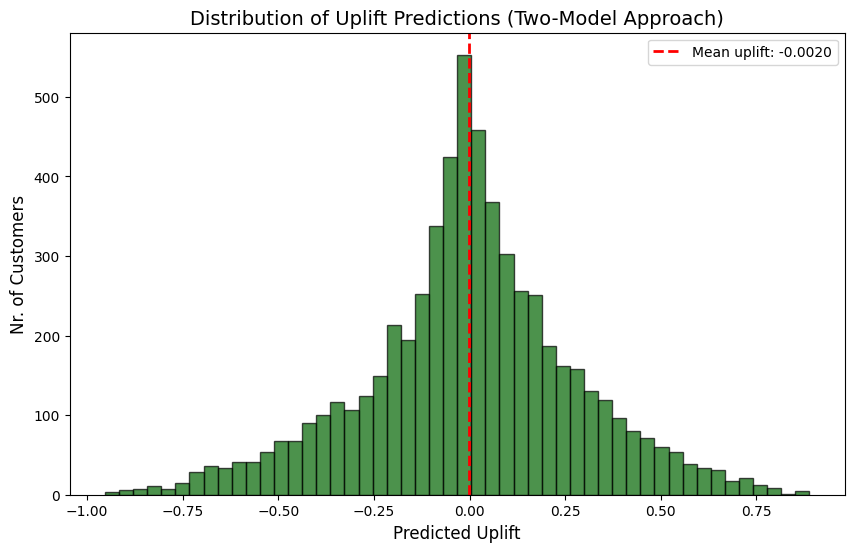

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.hist(uplift_predictions, bins = 50, alpha = 0.7, color = 'darkgreen', edgecolor = 'black')

plt.axvline(x = uplift_predictions.mean(), color = 'red', linestyle = '--', 
            linewidth = 2, label = f'Mean uplift: {uplift_predictions.mean():.4f}')

plt.xlabel('Predicted Uplift', fontsize = 12)
plt.ylabel('Nr. of Customers', fontsize = 12)
plt.title('Distribution of Uplift Predictions (Two-Model Approach)', fontsize = 14)
plt.legend()
plt.show()

#### Results Dataframe ####

In [15]:
results_df = pd.DataFrame({
    'prob_if_treated': prob_treated,
    'prob_if_control': prob_control,
    'uplift': uplift_predictions,
    'actual_treatment': test_treatments.values,
    'actual_outcome': y_test.values
})

#### Plotting Uplift-Chart ####

In [16]:
from deciles_function import uplift_by_decile

decile_df = uplift_by_decile(
    results_df,
    treat_col = "actual_treatment",
    outcome_col = "actual_outcome",
    uplift_col = "uplift",
)
decile_df

,decile,n_customers,avg_predicted_uplift,actual_uplift,treated_purchase_rate,control_purchase_rate
0,0,600,0.297185,0.073074,0.353896,0.280822
1,1,600,0.039096,0.017692,0.172297,0.154605
2,2,600,0.001935,0.031670,0.432343,0.400673
3,3,600,0.000078,-0.011951,0.952218,0.964169
4,4,600,0.000016,-0.004750,0.985816,0.990566
5,5,599,-0.000013,-0.006633,0.983333,0.989967
6,6,601,-0.000112,-0.002864,0.910494,0.913357
7,7,600,-0.001781,0.067412,0.421927,0.354515
8,8,600,-0.027449,-0.011204,0.107843,0.119048
9,9,600,-0.319068,-0.053876,0.327703,0.381579


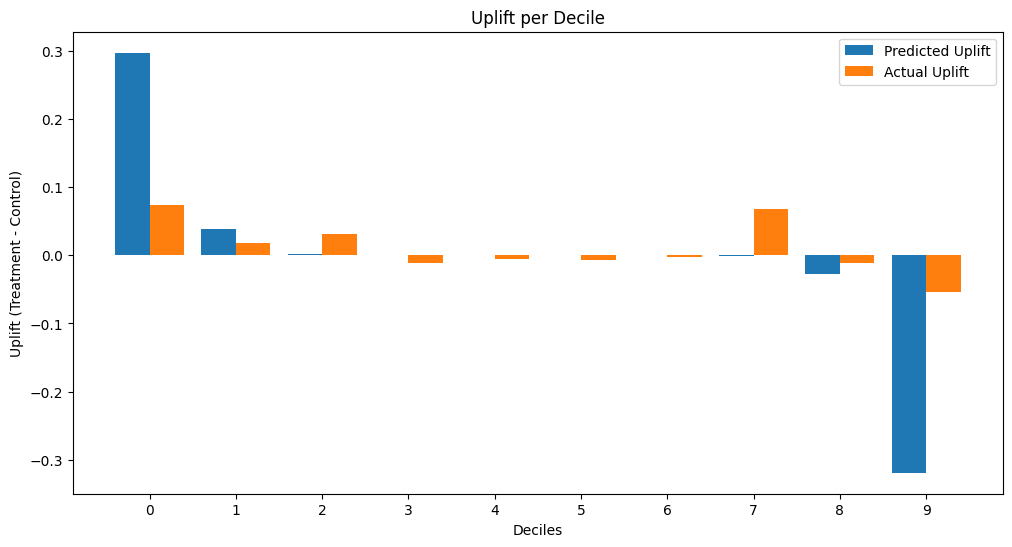

In [ ]:
plt.figure(figsize = (12, 6))

deciles = np.arange(len(decile_df))
pred = decile_df['avg_predicted_uplift']
act  = decile_df['actual_uplift']

plt.bar(deciles - 0.2, pred, width = 0.4, label = 'Predicted Uplift')
plt.bar(deciles + 0.2, act,  width = 0.4, label = 'Actual Uplift')


plt.xlabel('Deciles')
plt.ylabel('Uplift (Treatment - Control)')
plt.title('Uplift per Decile')
plt.xticks(deciles)
plt.legend()

plt.show()


### Class Transformation Method ###
This method was introduced by [Jaskowski and Jaroszewicz (2012)](https://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf).
It creates the following target variable:
$$Z_i= Y_i^{obs} W_i + (1-Y_i^{obs})(1-W_i)$$
so
$$
Z_i = 
\begin{cases}
    1 & \text{if } W_i = T \text{ and } Y_i = 1, \\
    1 & \text{if } W_i = C \text{ and } Y_i = 0, \\
    0 & \text{otherwise.}
\end{cases}
$$

Under the assumption that control and treated groups are balanced across all profiles of individual( meaning $p(X_i = x) = 1/2$ for all x) it can be proven that:
$$\tau(X_i) = 2P(Z_i = 1\mid X_i) - 1$$

Thus, to model uplift one just needs to estimate $P(Z_i = 1\mid X_i)$, for which any classifier can be used.

#### Create Target Variable ####

In [18]:
X_train_combined = X_train.copy()

Z_train = ((X_train_combined["treatment"] == 1) & (y_train == 1)) | \
    ((X_train_combined["treatment"] == 0) & (y_train == 0))
    
Z_train = Z_train.astype(int)


#### Checking treatment distribution again ####
As above, the treatment/ control distribution is very balanced. Thus, no sample weights are necessary.

In [21]:
treatment_dist = X_train["treatment"].value_counts(normalize=True)
print(f"Treatment Distribution:{treatment_dist}")

Treatment Distribution:treatment
1    0.501643
0    0.498357
Name: proportion, dtype: float64


#### Train the model ####

In [22]:
X_train_features = X_train_combined.drop(columns=["treatment"])

model_transform = XGBClassifier(
    eval_metric = "logloss",
    random_state = 42,
    n_estimators = 100,
    max_depth = 6,
    learning_rate = 0.3
)

model_transform.fit(X_train_features, Z_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
X_test_features = X_test.drop(columns=["treatment"])

prob_z_one = model_transform.predict_proba(X_test_features)[:, 1]

uplift_predictions = 2 * prob_z_one - 1

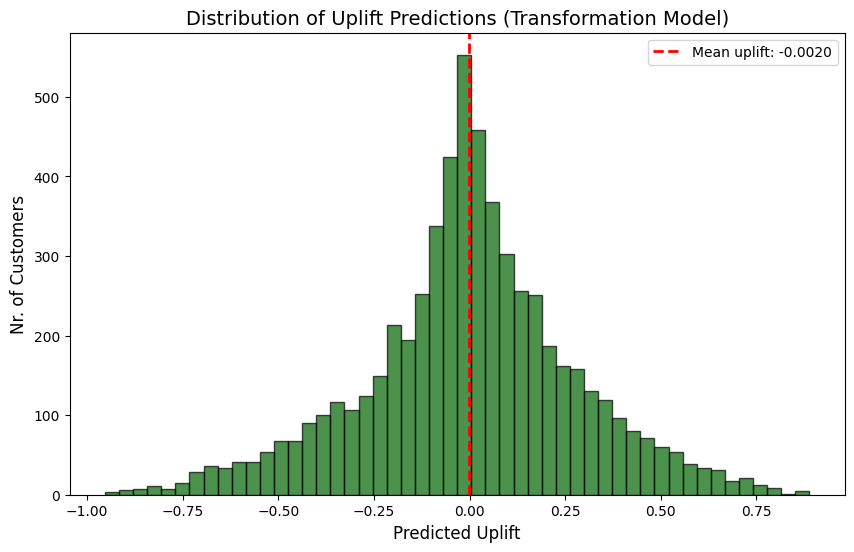

In [30]:
plt.figure(figsize=(10, 6))

plt.hist(uplift_predictions, bins = 50, alpha = 0.7, color = "darkgreen", edgecolor = "black")

plt.axvline(x = uplift_predictions.mean(), color = "red", linestyle = "--", 
            linewidth = 2, label = f"Mean uplift: {uplift_predictions.mean():.4f}")

plt.xlabel("Predicted Uplift", fontsize = 12)
plt.ylabel("Nr. of Customers", fontsize = 12)
plt.title("Distribution of Uplift Predictions (Transformation Model)", fontsize = 14)
plt.legend()
plt.show()

#### Results Dataframe ####

In [32]:
results_trans = pd.DataFrame({
    'prob_z_one': prob_z_one,
    'uplift': uplift_predictions,
    'actual_treatment': X_test['treatment'].values,
    'actual_outcome': y_test.values
})

#### Plotting Uplift-Chart ####

In [35]:
from deciles_function import uplift_by_decile
deciles_trans = uplift_by_decile(
    results_trans,
    uplift_col = "uplift",
    treat_col = "actual_treatment",
    outcome_col = "actual_outcome"
)
deciles_trans

,decile,n_customers,avg_predicted_uplift,actual_uplift,treated_purchase_rate,control_purchase_rate
0,0,600,0.501627,0.034780,0.544521,0.509740
1,1,600,0.272352,-0.021260,0.512987,0.534247
2,2,600,0.157298,0.015702,0.626263,0.610561
3,3,600,0.078384,0.005451,0.634483,0.629032
4,4,587,0.021619,0.035255,0.661130,0.625874
5,5,612,-0.023094,0.056971,0.600660,0.543689
6,6,599,-0.072966,0.016803,0.432343,0.415541
7,7,602,-0.147202,0.014794,0.562092,0.547297
8,8,600,-0.274171,-0.027646,0.559603,0.587248
9,9,600,-0.532507,-0.058254,0.504886,0.563140


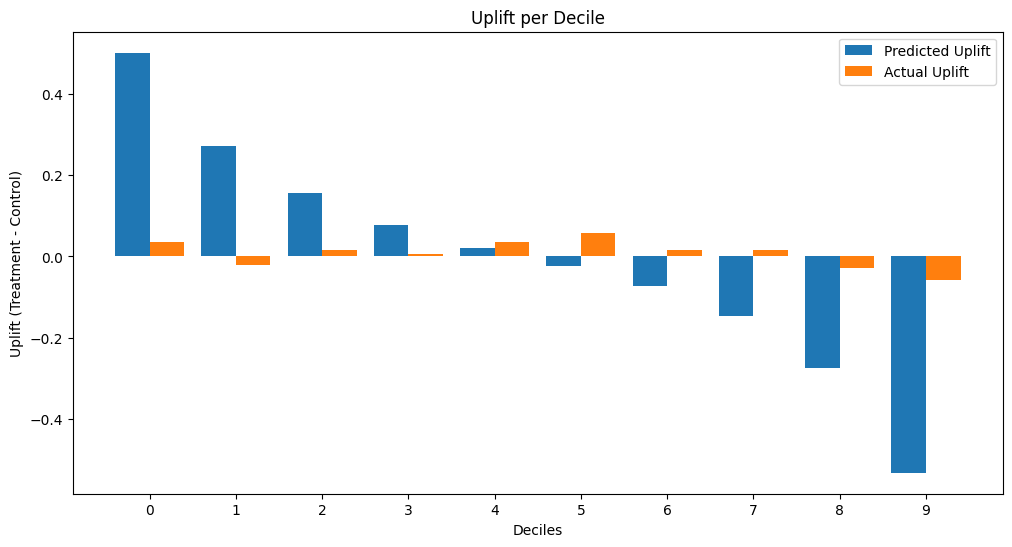

In [37]:
plt.figure(figsize = (12, 6))

deciles = np.arange(len(deciles_trans))
pred = deciles_trans['avg_predicted_uplift']
act  = deciles_trans['actual_uplift']

plt.bar(deciles - 0.2, pred, width = 0.4, label = 'Predicted Uplift')
plt.bar(deciles + 0.2, act,  width = 0.4, label = 'Actual Uplift')


plt.xlabel('Deciles')
plt.ylabel('Uplift (Treatment - Control)')
plt.title('Uplift per Decile')
plt.xticks(deciles)
plt.legend()

plt.show()